Find a dataset of your choice at Kaggle (it can your project dataset) and split into training and validation set.

**Assumption:** You already know (tentatively) what hyperparameters are good for your dataset.

There are two objectives in this activity:
* Implement automatic stopping of training if the accuracy does not improve for certain epochs.
* Implement automatic saving of the best model (best on the validation set)

In [1]:
# Import modules
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from functools import *
from google.colab import files
import time

%tensorflow_version 1.x
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


TensorFlow 1.x selected.


In [2]:
uploaded = files.upload()
file_name = "heart.csv"

Saving heart.csv to heart.csv


### Reading Data and Prepare Dataset

In [3]:
import pandas as pd
dataset = pd.read_csv(file_name, delimiter=',')
print(dataset.shape)
dataset.head()

(303, 14)


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


In [0]:
# Shuffle the dataset
# NOTE: shuffle dataframe in-place and reset the index
dataset = dataset.sample(frac=1).reset_index(drop=True)

# Convert Pandas Dataframe to Numpy dArray
dataset_np = dataset.values
X = dataset.drop('age', axis='columns').values
Y = dataset['age'].values

### Percent to Split

In [5]:
# Index for 30%
index_30percent = int(0.3 * len(dataset_np[:, 0]))
print(index_30percent)

90


### Validation Dataset

In [0]:
# Split into training and validation
XVALID = X[:index_30percent, :]
YVALID = Y[:index_30percent]

XTRAIN = X[index_30percent:, :]
YTRAIN = Y[index_30percent:]

## Mean normalization
min = XTRAIN.min(axis = 0) 
max = XTRAIN.max(axis = 0) 
mean = XTRAIN.mean(axis = 0)
XTRAIN = (XTRAIN - mean) / (max - min)
XVALID = (XVALID - mean) / (max - min)

## Rescaling
Ymax = YTRAIN.max()
YTRAIN = YTRAIN / Ymax
YVALID = YVALID / Ymax

In [0]:
def learning_curves(model_history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))
    ax1.plot(model_history.history['loss'])
    ax1.plot(model_history.history['val_loss'])
    ax1.set_ylabel('loss')
    ax1.set_xlabel('epoch')
    ax1.legend(['training loss data', 'validation loss data'], loc='upper right')

    ax2.plot(model_history.history['mean_absolute_error'])
    ax2.plot(model_history.history['val_mean_absolute_error'])
    ax2.set_ylabel('error')
    ax2.set_xlabel('epoch')
    ax2.legend(['training error data', 'validation error data'], loc='upper right')

    fig.show()

## Base Model
* This is base model with one hidden layer that has half the neuron of the previous top layer.

In [8]:
model = Sequential()
model.add(Dense(13, input_dim=len(XTRAIN[0, :]), activation='relu'))
model.add(Dense(7, activation='relu'))
model.add(Dense(1, activation='linear'))

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [0]:
# Normal Dataset
model.compile(loss='mse', optimizer = 'adam', metrics=['mae'])

start_time = time.time()
history = model.fit(XTRAIN, YTRAIN, validation_data=(XVALID, YVALID), epochs = 1024, batch_size=100, verbose=0)
noCallBackTime = time.time() - start_time

### Learning Curves of Base Model

90/90 [==============================] - 0s 59us/sample - loss: 0.0231 - mean_absolute_error: 0.1204
Last Val Loss: 0.023122824728488922
Last Val MAE: 0.12041461
{'batch_size': 100, 'epochs': 1024, 'steps': None, 'samples': 213, 'verbose': 0, 'do_validation': True, 'metrics': ['loss', 'mean_absolute_error', 'val_loss', 'val_mean_absolute_error']}
Time (sec): 17.652138471603394


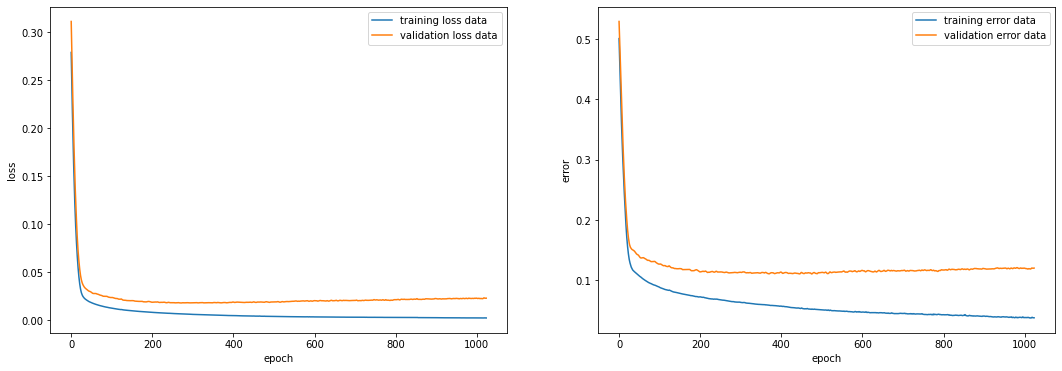

In [10]:
model.evaluate(XVALID, YVALID)
print("Last Val Loss: %s" % history.history['val_loss'][-1])
print("Last Val MAE: %s" % history.history['val_mean_absolute_error'][-1])
print(history.params)
learning_curves(history)

print("Time (sec): %s" % noCallBackTime)

## Early Stopping Model

In [0]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# File name must be in quotes
callback_a = ModelCheckpoint(filepath = "your_model.hdf5", monitor='val_loss', save_best_only = True, save_weights_only = True, verbose = 1)

# The patience value can be 10, 20, 100, etc. depending on when your model starts to overfit
callback_b = EarlyStopping(monitor='val_loss', mode='min', patience=20, verbose=1)

modelES = Sequential()
modelES.add(Dense(13, input_dim=len(XTRAIN[0, :]), activation='relu'))
modelES.add(Dense(7, activation='relu'))
modelES.add(Dense(1, activation='linear'))

In [12]:
modelES.compile(loss='mse', optimizer = 'adam', metrics=['mae'])

start_time = time.time()
historyES = modelES.fit(XTRAIN, YTRAIN, validation_data=(XVALID, YVALID), epochs=1024, batch_size=100, callbacks = [callback_a, callback_b]) 
callBackTime = time.time() - start_time

Train on 213 samples, validate on 90 samples
Epoch 1/1024
100/213 [=============>................] - ETA: 0s - loss: 0.4358 - mean_absolute_error: 0.6425
Epoch 00001: val_loss improved from inf to 0.40434, saving model to your_model.hdf5
213/213 [==============================] - 0s 578us/sample - loss: 0.4263 - mean_absolute_error: 0.6338 - val_loss: 0.4043 - val_mean_absolute_error: 0.6129
Epoch 2/1024
100/213 [=============>................] - ETA: 0s - loss: 0.4098 - mean_absolute_error: 0.6222
Epoch 00002: val_loss improved from 0.40434 to 0.38550, saving model to your_model.hdf5
213/213 [==============================] - 0s 83us/sample - loss: 0.4060 - mean_absolute_error: 0.6180 - val_loss: 0.3855 - val_mean_absolute_error: 0.5976
Epoch 3/1024
100/213 [=============>................] - ETA: 0s - loss: 0.3887 - mean_absolute_error: 0.6024
Epoch 00003: val_loss improved from 0.38550 to 0.36728, saving model to your_model.hdf5
213/213 [==============================] - 0s 83us/samp

### Learning Curves of Early Stopping Model

90/90 [==============================] - 0s 75us/sample - loss: 0.0163 - mean_absolute_error: 0.0998
Last Val Loss: 0.016270676627755165
Last Val MAE: 0.09980048
{'batch_size': 100, 'epochs': 1024, 'steps': None, 'samples': 213, 'verbose': 0, 'do_validation': True, 'metrics': ['loss', 'mean_absolute_error', 'val_loss', 'val_mean_absolute_error']}
Time (sec): 5.800955057144165


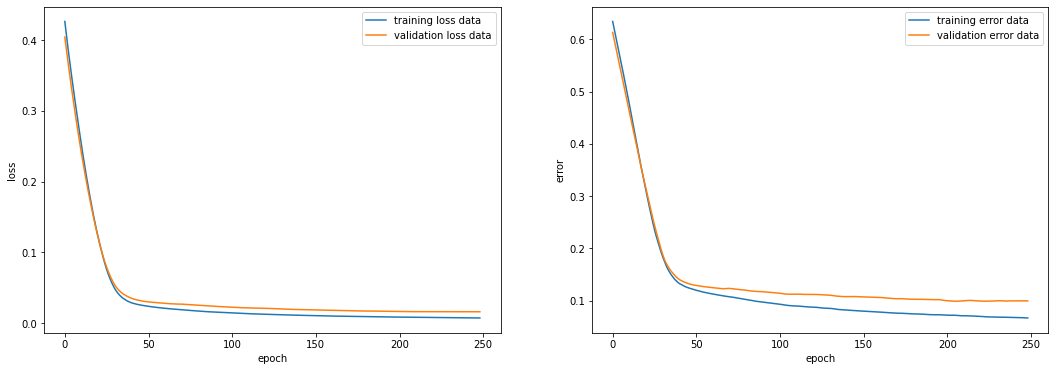

In [13]:
modelES.evaluate(XVALID, YVALID)
print("Last Val Loss: %s" % historyES.history['val_loss'][-1])
print("Last Val MAE: %s" % historyES.history['val_mean_absolute_error'][-1])
print(historyES.params)
learning_curves(historyES)

print("Time (sec): %s" % callBackTime)

## Evaluation

Almost always, training with early stopping finishes faster (because it stops early). Approximately, how long does it take for your training to finish with and without early stopping?

In [15]:
# No Callback Model (Base Model)
print("No Callback Model Time (sec): %s" % noCallBackTime)

# Callback Model
print("Callback Model Time (sec): %s" % callBackTime)

No Callback Model Time (sec): 17.652138471603394
Callback Model Time (sec): 5.800955057144165


When model checkpointing, your checkpointed model will almost always be more accurate on the validation set. What is the accuracy/MAE on the Validation set with and without model checkpointing?

In [0]:
from sklearn.metrics import mean_absolute_error
def model_evaluation(xtrain, ytrain, xvalid, yvalid, model):
    scores = model.evaluate(xvalid, yvalid)
    for i in range(len(scores)):
        print("%s: %.2f%%" % (model.metrics_names[i], scores[i]*100))

    pred_train = model.predict(xtrain)
    print("Training MAE: %s" % mean_absolute_error(ytrain, pred_train))

    pred = model.predict(xvalid)
    print("Validation MAE: %s" % mean_absolute_error(yvalid, pred))

In [30]:
print("~~~No Callback Model MAE~~~")
model_evaluation(XTRAIN, YTRAIN, XVALID, YVALID, model)

print("\n\n~~~Callback Model MAE~~~")
modelES.load_weights("your_model.hdf5")
model_evaluation(XTRAIN, YTRAIN, XVALID, YVALID, modelES)

~~~No Callback Model MAE~~~
90/90 [==============================] - 0s 95us/sample - loss: 0.0231 - mean_absolute_error: 0.1204
loss: 2.31%
mean_absolute_error: 12.04%
Training MAE: 0.03782262504337023
Validation MAE: 0.12041460648071543


~~~Callback Model MAE~~~
90/90 [==============================] - 0s 53us/sample - loss: 0.0162 - mean_absolute_error: 0.0997
loss: 1.62%
mean_absolute_error: 9.97%
Training MAE: 0.06885332771499204
Validation MAE: 0.09970130173846932
